## MNIST Image Segmentation Dataset
### Wesley Mitchell

In [1]:
import tensorflow as tf
import os 
import tensorflow.keras as keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle

2023-05-09 21:50:34.781837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Create the Dataset

In [2]:
(x_single_train, y_single_train), (x_single_valid, y_single_valid) = keras.datasets.mnist.load_data()

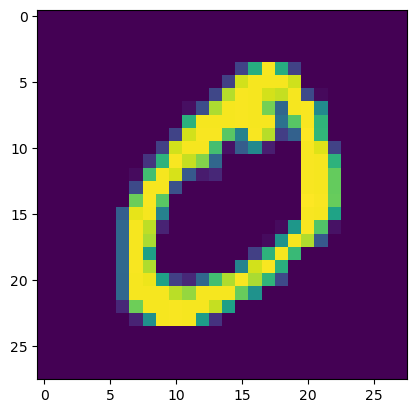

In [3]:
x_single_train.shape
plt.imshow(x_single_train[1])
plt.show()

In [4]:
x_single_train.shape

(60000, 28, 28)

In [5]:
x_single_valid.shape

(10000, 28, 28)

In [6]:
def stitch_images_randomly(images, final_width, final_height, min_scale, max_scale):
    final_image = np.zeros((final_height, final_width), dtype=np.uint8)

    def generate_random_position(image_width, image_height):
        x = random.randint(0, final_width - image_width)
        y = random.randint(0, final_height - image_height)
        return x, y

    def is_overlap(position1, size1, position2, size2):
        x1, y1 = position1
        w1, h1 = size1
        x2, y2 = position2
        w2, h2 = size2
        

        return not (x1 + w1 <= x2 or x1 >= x2 + w2 or y1 + h1 <= y2 or y1 >= y2 + h2)
    
    def random_scale_image(image_array, min_scale, max_scale):
        scale_factor = random.uniform(min_scale, max_scale)

        image = Image.fromarray(image_array)

        new_width = int(image.width * scale_factor)
        new_height = int(image.height * scale_factor)

        resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

        resized_image_array = np.array(resized_image)

        return resized_image_array

    positions = []
    
    scaled_images = []
    
    for i in range(len(images)):
        scaled_images.append(random_scale_image(images[i], min_scale, max_scale))
    scaled_images = np.array(scaled_images, dtype=object)
        
    for image in scaled_images:
        image_height, image_width = image.shape
        while True:
            position = generate_random_position(image_width, image_height)
            if not any(is_overlap(position, image.shape[:2][::-1], pos, img_arr.shape[:2][::-1]) for pos, img_arr in zip(positions, images)):
                positions.append(position)
                break

    for image, position in zip(scaled_images, positions):
        x, y = position
        h, w = image.shape
        final_image[y:y+h, x:x+w] = image

    return final_image

In [7]:
final_image_height = 100
final_image_width = 100
num_images = 1
variations = 4
images_per_class_train = len(x_single_train) // 10
print(images_per_class_train)
images_per_class_valid = len(x_single_valid) // 10
scales = [(1, 2, 1), (.5, 1.3, 2), (.5, 1.3, 3), (.5, 1.3, 4)] 

x_train_stitched = []
y_train_stitched = [] 
x_valid_stitched = []
y_valid_stitched = []
for vari in range(variations):
    for i in range(0, images_per_class_train * scales[vari][2], scales[vari][2]):
        x_train_stitched.append(stitch_images_randomly(x_single_train[i:i+scales[vari][2]], final_image_width, final_image_height, scales[vari][0], scales[vari][1]))
        y_train_stitched.append(tuple(y_single_train[j] for j in range(i, i+scales[vari][2])))

    for i in range(0, images_per_class_valid * scales[vari][2], scales[vari][2]):
        x_valid_stitched.append(stitch_images_randomly(x_single_valid[i:i+scales[vari][2]], final_image_width, final_image_height, scales[vari][0], scales[vari][1]))
        y_valid_stitched.append(tuple(y_single_valid[j] for j in range(i, i+scales[vari][2])))

6000


/tmp/ipykernel_724/282259415.py:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)


In [8]:
x_train_stitched = np.array(x_train_stitched)
y_train_stitched = np.array(y_train_stitched, dtype=object)

x_valid_stitched = np.array(x_valid_stitched)
y_valid_stitched = np.array(y_valid_stitched, dtype=object)

x_train_stitched, y_train_stitched = shuffle(x_train_stitched, y_train_stitched)

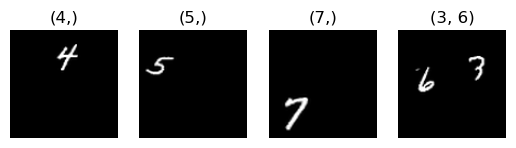

In [9]:
plt.subplots_adjust(hspace=0.3)
plt.subplot(1, 4, 1)
plt.title(y_train_stitched[0])
plt.axis('off')
plt.imshow(x_train_stitched[0], cmap='gray')

plt.subplot(1, 4, 2)
plt.title(y_train_stitched[1])
plt.axis('off')
plt.imshow(x_train_stitched[1], cmap='gray')

plt.subplot(1, 4, 3)
plt.title(y_train_stitched[2])
plt.axis('off')
plt.imshow(x_train_stitched[2], cmap='gray')

plt.subplot(1, 4, 4)
plt.title(y_train_stitched[3])
plt.axis('off')
plt.imshow(x_train_stitched[3], cmap='gray')

plt.show()

#### Save the Dataset to a Directory

In [11]:
train_directory = 'Stitched_MNIST/train/images'
valid_directory = 'Stitched_MNIST/validation/images'

#function to save an individual image
def save_image(image_array, file_path):
    image = Image.fromarray(image_array)
    image.save(file_path)


In [17]:
for i, img in enumerate(x_train_stitched):
    file_name = f'image_{i:05}.png'
    file_path = os.path.join(train_directory, file_name)
    save_image(img, file_path)

In [17]:
train_labels_file = open(f"{train_directory}/labels.txt", "w")

for label in y_train_stitched:
    train_labels_file.write(str(label))
    
train_labels_file.close()

AttributeError: '_io.TextIOWrapper' object has no attribute 'writeline'

In [18]:
for i, img in enumerate(x_valid_stitched):
    file_name = f'image_{i:05}.png'
    file_path = os.path.join(valid_directory, file_name)
    save_image(img, file_path)